In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [2]:
# df_F = pd.read_csv("model_building.csv",converters={'CIF_ID': str})

In [3]:
# df_F.columns

In [4]:
# df_F.shape

In [5]:
df_F = pd.read_csv("Undersampled_data2.csv",converters={'CIF_ID': str})
# df_2 = pd.read_csv("CIPSCORE.csv",converters={'CIF_ID': str})

In [6]:
# df_2.columns

In [7]:
# df_F = pd.merge(df_1, df_2, how='left', on = 'CIF_ID')

In [8]:
df_F.head(5)

,CIF_ID,CUST_AGE,AGE_WITH_BANK,DIS_AMT,REP_PERD_MTHS,FLOW_AMT,NO_OF_INSTALLMENTS,min_cred_amt_6_months,max_cred_amt_6_months,avg_cred_amt_6_months,...,age_with_bank_9-11,age_with_bank_12-15,first_otg_trans_0-4,first_otg_trans_5-8,first_otg_trans_9-11,first_otg_trans_12-15,no_of_inactive_months_otg_0- <3,no_of_inactive_months_otg_3- <6,no_of_inactive_months_otg_6- <9,no_of_inactive_months_otg_9 - 11
0,0008264,32,15,669500.0,60,16295.0,1,9.00,669500.0,34701.441860,...,0,1,1,0,0,0,1,0,0,0
1,0053272,38,12,2000000.0,60,48720.0,1,0.17,2000000.0,97066.649770,...,0,1,1,0,0,0,1,0,0,0
2,0076106,32,10,380700.0,60,9119.0,1,2.00,380700.0,23113.000000,...,1,0,1,0,0,0,1,0,0,0
3,0109326,33,8,2000000.0,60,48124.0,1,2.00,2000000.0,91375.673333,...,1,0,1,0,0,0,1,0,0,0
4,0145595,33,6,50000.0,1,50617.0,1,1.00,150000.0,10758.582674,...,0,0,0,1,0,0,1,0,0,0


In [9]:
# cif_id_to_check = '0097577'  # Specify the CIF_ID you want to check

# Find the row with the specific CIF_ID
# row = df_F.loc[df_F['CIF_ID'] == cif_id_to_check]

# Get the age value from the row
# age = row['CUST_AGE'].values[0]

# print(f"The age of CIF_ID {cif_id_to_check} is: {age}")


In [10]:
# cif_ids = df_F['CIF_ID'].tolist()

In [11]:
# cif_ids2 = df['CIF_ID'].unique().tolist()

In [12]:
# len(cif_ids2)

In [13]:
# print(cif_ids)

In [14]:
# Create a DataFrame from the CIF_IDs
# df = pd.DataFrame({'CIF_ID': cif_ids})

# Export the DataFrame to an Excel file
# df.to_excel('cif_ids.xlsx', index=False)

In [15]:
len(df_F)

377

In [16]:
# df_F['cust_age_flag'] = [0 if x < 35 else 1 for x in df_F['CUST_AGE']]
# df_F['age_with_im_flag'] = [0 if x < 3 else 1 for x in df_F['AGE_WITH_BANK']]
# df_F['eod_flag'] = [0 if x < 5000 else 1 for x in df_F['median_eod_bal_6_months']]
# df_F['first_otg_trans_flag'] = [0 if x >= 2 else 1 for x in df_F['first_otg_trans']]

In [17]:
df_F.describe().T

,count,mean,std,min,25%,50%,75%,max
CUST_AGE,377.0,35.427056,9.233704e+00,20.000000,28.000000,34.000000,4.100000e+01,6.500000e+01
AGE_WITH_BANK,377.0,3.938992,3.378435e+00,0.000000,1.000000,3.000000,5.000000e+00,1.500000e+01
DIS_AMT,377.0,815473.995199,8.859072e+05,2975.450000,171200.000000,428900.000000,1.100000e+06,3.000000e+06
REP_PERD_MTHS,377.0,48.885942,1.777026e+01,1.000000,36.000000,60.000000,6.000000e+01,6.000000e+01
FLOW_AMT,377.0,24401.245225,2.866564e+04,1043.000000,6305.000000,12888.000000,3.261800e+04,2.492640e+05
NO_OF_INSTALLMENTS,377.0,1.045093,2.202116e-01,1.000000,1.000000,1.000000,1.000000e+00,3.000000e+00
min_cred_amt_6_months,377.0,3965.797692,1.100283e+04,0.040000,2.000000,6.000000,1.000000e+03,9.738300e+04
max_cred_amt_6_months,377.0,907582.287931,1.384632e+06,656.930000,180000.000000,450000.000000,1.200000e+06,2.023608e+07
avg_cred_amt_6_months,377.0,71898.717100,1.125224e+05,95.082191,21405.250000,38017.142857,7.542977e+04,1.148812e+06
median_cred_amt_6_months,377.0,30235.990477,7.605612e+04,2.000000,2525.000000,12399.500000,3.024300e+04,9.416000e+05


In [18]:
df_F['DEFAULT_STATUS_ENCODED'].value_counts()

1    200
0    177
Name: DEFAULT_STATUS_ENCODED, dtype: int64

In [19]:
df_1 = df_F.copy()

In [20]:
df_1.columns

Index(['CIF_ID', 'CUST_AGE', 'AGE_WITH_BANK', 'DIS_AMT', 'REP_PERD_MTHS',
       'FLOW_AMT', 'NO_OF_INSTALLMENTS', 'min_cred_amt_6_months',
       'max_cred_amt_6_months', 'avg_cred_amt_6_months',
       'median_cred_amt_6_months', 'avg_monthly_cred_count_6_months',
       'avg_eod_bal_6_months', 'median_eod_bal_6_months',
       'min_debit_amt_6_months', 'max_debit_amt_6_months',
       'avg_debit_amt_6_months', 'median_debit_amt_6_months',
       'avg_monthly_debit_count_6_months', 'no_of_non_loan_accounts',
       'no_of_loan_accounts', 'first_otg_trans', 'number_of_months_active_otg',
       'avg_otg_tran_amt', 'median_otg_tran_amount',
       'avg_monthly_otg_trans_count', 'avg_debit_to_credit_amt_ratio',
       'median_debit_to_credit_amt_ratio', 'DEFAULT_STATUS_ENCODED',
       'number_of_inactive_months_otg', 'MARITALSTATUS_MARRIED',
       'MARITALSTATUS_SINGLE', 'SEGMENTATION_CLASS_BL03_OR_BLO5',
       'OTG_TRANSACTING_FLAG', 'cust_age_19-20', 'cust_age_21-30',
       'cust_

In [21]:
columns_to_drop = ['DIS_AMT', 'REP_PERD_MTHS','FLOW_AMT', 'NO_OF_INSTALLMENTS']
df_F.drop(columns_to_drop,axis=1,inplace=True)

In [22]:
df_F = pd.concat([df_F[df_F['DEFAULT_STATUS_ENCODED'] == 0],
                            df_F[df_F['DEFAULT_STATUS_ENCODED'] == 1].sample(150)])

In [23]:
cols_selected_for_rfe = ['CUST_AGE', 'AGE_WITH_BANK','min_cred_amt_6_months',
       'max_cred_amt_6_months', 'avg_cred_amt_6_months',
       'median_cred_amt_6_months', 'avg_monthly_cred_count_6_months',
       'avg_eod_bal_6_months', 'median_eod_bal_6_months',
       'min_debit_amt_6_months', 'max_debit_amt_6_months',
       'avg_debit_amt_6_months', 'median_debit_amt_6_months',
       'avg_monthly_debit_count_6_months', 'no_of_non_loan_accounts',
       'no_of_loan_accounts', 'first_otg_trans', 'number_of_months_active_otg',
       'avg_otg_tran_amt', 'median_otg_tran_amount',
       'avg_monthly_otg_trans_count', 'avg_debit_to_credit_amt_ratio',
       'median_debit_to_credit_amt_ratio',
       'number_of_inactive_months_otg', 'MARITALSTATUS_MARRIED',
       'MARITALSTATUS_SINGLE', 'SEGMENTATION_CLASS_BL03_OR_BLO5',
       'OTG_TRANSACTING_FLAG', 'cust_age_19-20', 'cust_age_21-30',
       'cust_age_31-40', 'cust_age_41-50', 'cust_age_51-60', 'cust_age_61-70',
       'cust_age_71-80', 'age_with_bank_0-4', 'age_with_bank_5-8',
       'age_with_bank_9-11', 'age_with_bank_12-15', 'first_otg_trans_0-4',
       'first_otg_trans_5-8', 'first_otg_trans_9-11', 'first_otg_trans_12-15',
       'no_of_inactive_months_otg_0- <3', 'no_of_inactive_months_otg_3- <6',
       'no_of_inactive_months_otg_6- <9', 'no_of_inactive_months_otg_9 - 11']

In [24]:
rfc = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(df_F[cols_selected_for_rfe], df_F['DEFAULT_STATUS_ENCODED'])

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=42), scoring='accuracy')

In [25]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 38


In [26]:
len(rfecv.cv_results_['mean_test_score'])

47

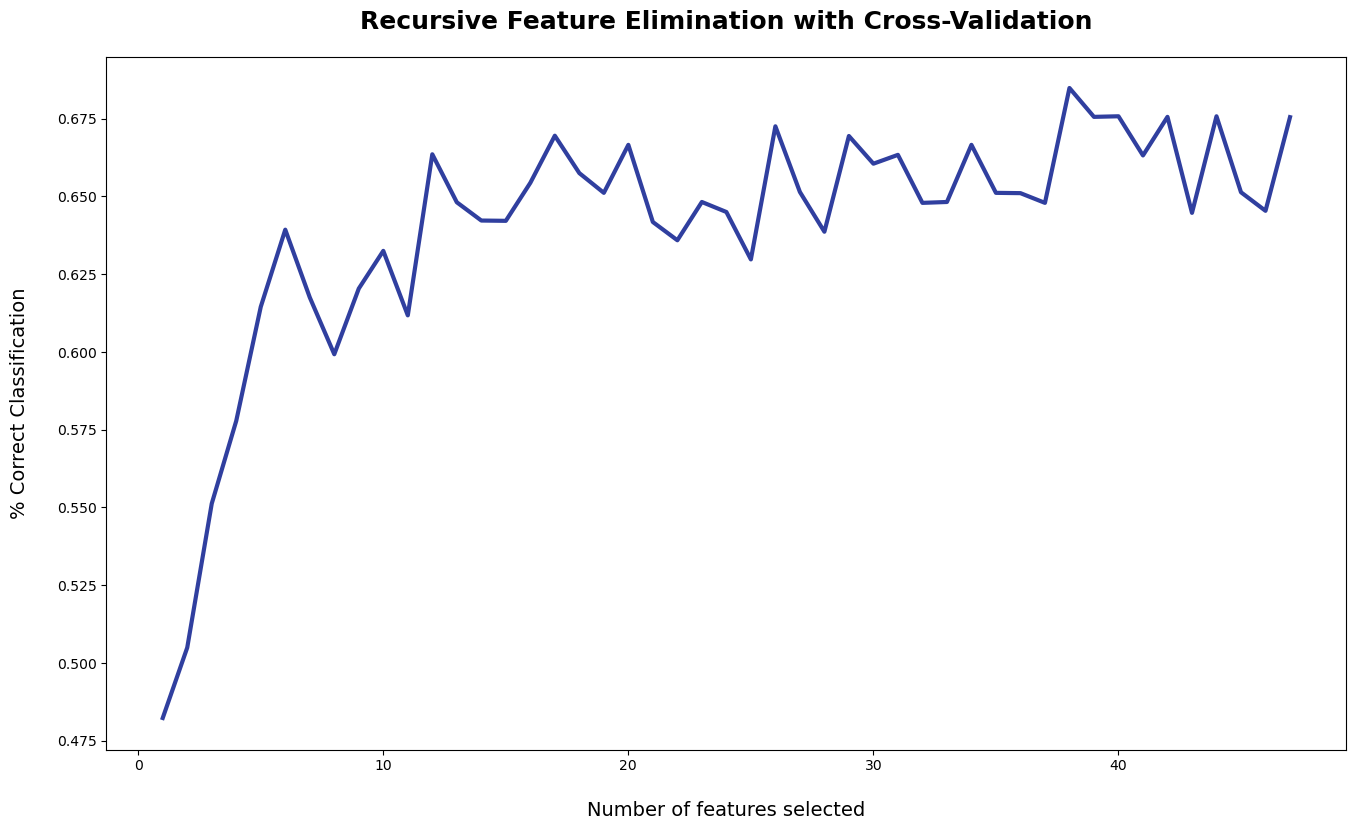

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], color='#303F9F', linewidth=3)

plt.show()

In [28]:
X = df_F[cols_selected_for_rfe]

In [29]:
X.head()

,CUST_AGE,AGE_WITH_BANK,min_cred_amt_6_months,max_cred_amt_6_months,avg_cred_amt_6_months,median_cred_amt_6_months,avg_monthly_cred_count_6_months,avg_eod_bal_6_months,median_eod_bal_6_months,min_debit_amt_6_months,...,age_with_bank_9-11,age_with_bank_12-15,first_otg_trans_0-4,first_otg_trans_5-8,first_otg_trans_9-11,first_otg_trans_12-15,no_of_inactive_months_otg_0- <3,no_of_inactive_months_otg_3- <6,no_of_inactive_months_otg_6- <9,no_of_inactive_months_otg_9 - 11
0,32,15,9.00,669500.0,34701.441860,3000.00,6.142857,21332.805616,758.89,1.00,...,0,1,1,0,0,0,1,0,0,0
1,38,12,0.17,2000000.0,97066.649770,40000.00,12.428571,56828.881515,14000.11,0.03,...,0,1,1,0,0,0,1,0,0,0
2,32,10,2.00,380700.0,23113.000000,8000.00,3.857143,25339.973208,19406.34,6.00,...,1,0,1,0,0,0,1,0,0,0
3,33,8,2.00,2000000.0,91375.673333,35.94,8.000000,125506.312397,0.00,1.00,...,1,0,1,0,0,0,1,0,0,0
4,33,6,1.00,150000.0,10758.582674,5250.00,39.000000,8065.292585,2014.07,1.00,...,0,0,0,1,0,0,1,0,0,0


In [30]:
# Get the indices where rfecv.support_ is False
indices_to_drop = np.where(rfecv.support_ == False)[0]

# Drop the columns using loc indexer
X.drop(X.columns[indices_to_drop], axis=1, inplace=True)

In [31]:
rfecv.estimator_.feature_importances_

array([0.05584666, 0.04398166, 0.03808619, 0.04226666, 0.04048379,
       0.03906105, 0.03883785, 0.05931744, 0.07241774, 0.04251421,
       0.0416429 , 0.0487651 , 0.03608842, 0.04375863, 0.01159741,
       0.00674074, 0.02469561, 0.02096077, 0.02507082, 0.02103592,
       0.05007699, 0.04368142, 0.05861737, 0.00959315, 0.00825684,
       0.00924272, 0.00439007, 0.00801422, 0.00800287, 0.00792405,
       0.00193524, 0.00268621, 0.00740745, 0.00403832, 0.00738424,
       0.00826467, 0.00376048, 0.00355412])

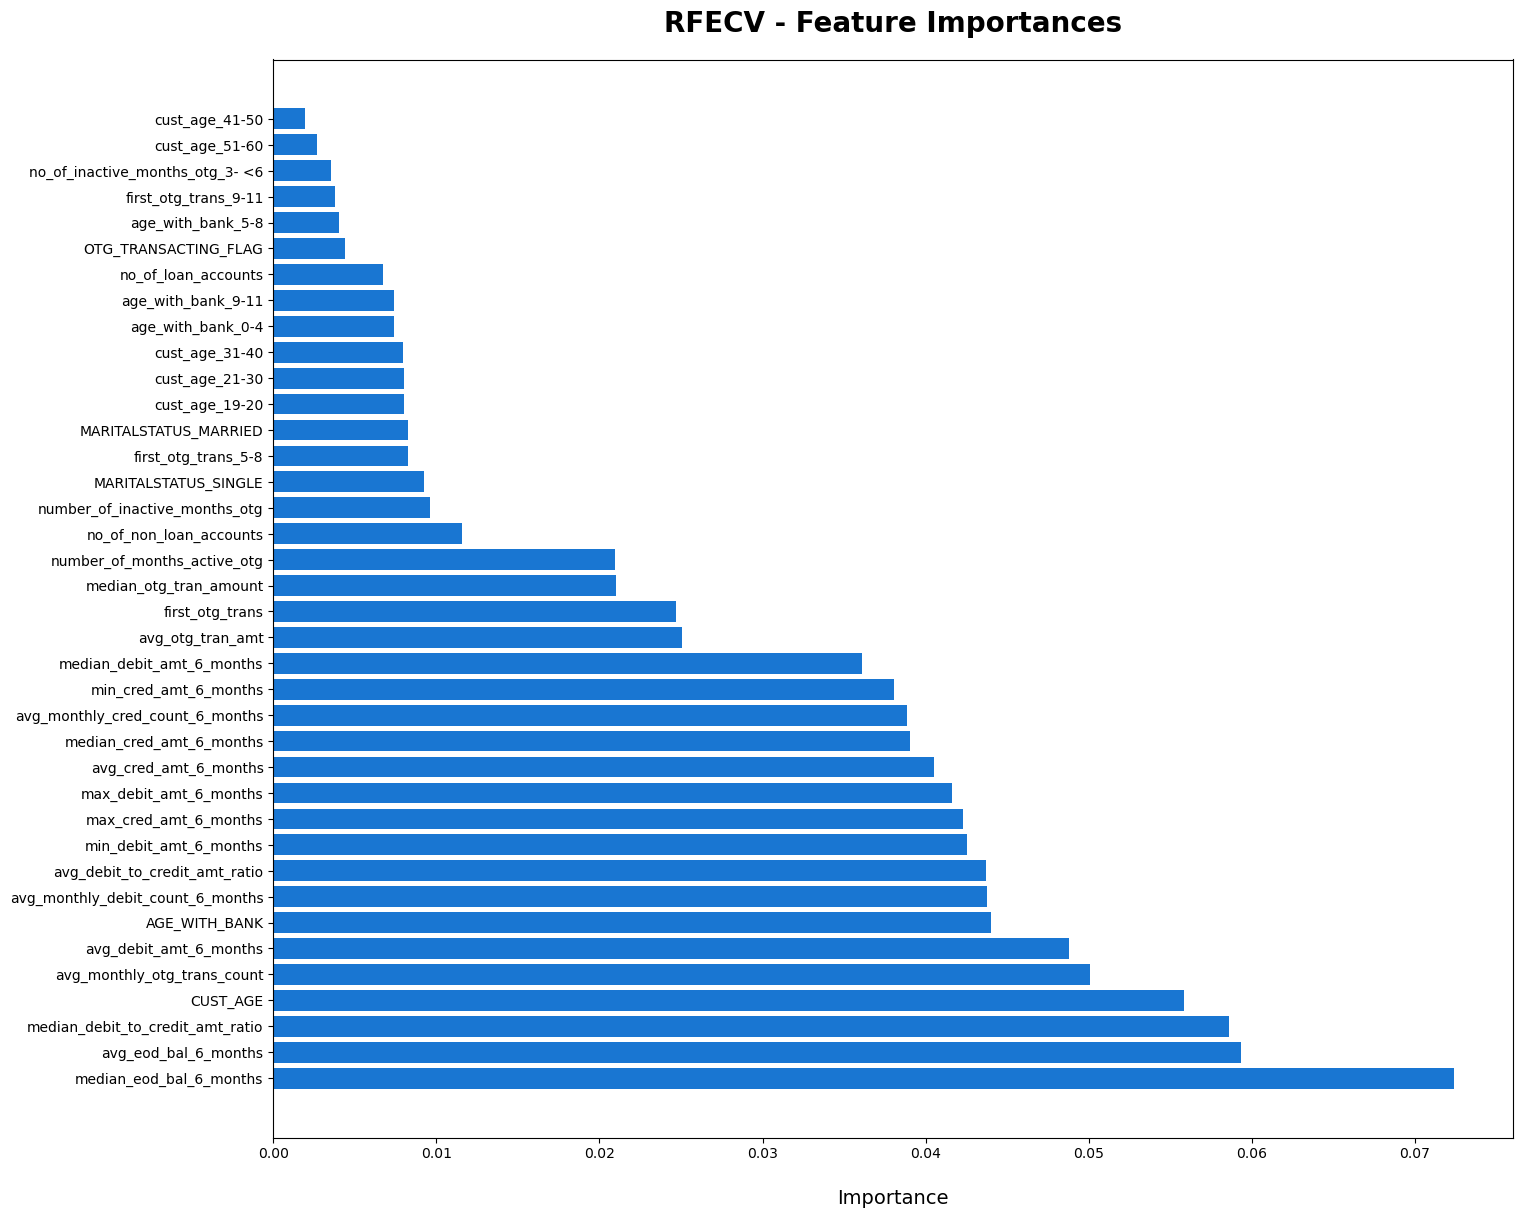

In [32]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [33]:
print(dset['attr'].to_list())

['median_eod_bal_6_months', 'avg_eod_bal_6_months', 'median_debit_to_credit_amt_ratio', 'CUST_AGE', 'avg_monthly_otg_trans_count', 'avg_debit_amt_6_months', 'AGE_WITH_BANK', 'avg_monthly_debit_count_6_months', 'avg_debit_to_credit_amt_ratio', 'min_debit_amt_6_months', 'max_cred_amt_6_months', 'max_debit_amt_6_months', 'avg_cred_amt_6_months', 'median_cred_amt_6_months', 'avg_monthly_cred_count_6_months', 'min_cred_amt_6_months', 'median_debit_amt_6_months', 'avg_otg_tran_amt', 'first_otg_trans', 'median_otg_tran_amount', 'number_of_months_active_otg', 'no_of_non_loan_accounts', 'number_of_inactive_months_otg', 'MARITALSTATUS_SINGLE', 'first_otg_trans_5-8', 'MARITALSTATUS_MARRIED', 'cust_age_19-20', 'cust_age_21-30', 'cust_age_31-40', 'age_with_bank_0-4', 'age_with_bank_9-11', 'no_of_loan_accounts', 'OTG_TRANSACTING_FLAG', 'age_with_bank_5-8', 'first_otg_trans_9-11', 'no_of_inactive_months_otg_3- <6', 'cust_age_51-60', 'cust_age_41-50']


In [34]:
important_cols = dset['attr'].to_list()

In [35]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_F,
                                                    df_F['DEFAULT_STATUS_ENCODED'],
                                                    test_size=0.23,
                                                    random_state=42,
                                                    stratify=df_F['DEFAULT_STATUS_ENCODED'])

In [36]:
# Handle class imbalance by applying a suitable method, such as oversampling or undersampling. 
# Here, we'll use the RandomOverSampler from the imblearn library

from imblearn.over_sampling import RandomOverSampler, SMOTE
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
sm = SMOTE(sampling_strategy=0.9,random_state=42)
X_train, y_train = sm.fit_resample(X_train,y_train)

In [37]:
X_train = X_train[important_cols]
X_test = X_test[important_cols]

In [38]:
X_train.shape

(258, 38)

In [39]:
# Scale the numerical columns
scaler = StandardScaler()
numerical_columns = important_cols

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [40]:
y_train.value_counts()

0    136
1    122
Name: DEFAULT_STATUS_ENCODED, dtype: int64

## Random Forest Classifier

In [41]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': np.arange(50, 150, 10),
    'max_depth': np.arange(7, 11, 1),
    'min_samples_split': np.arange(2, 6, 1),  # Adjusted range
    'min_samples_leaf': np.arange(1, 4, 1),  # Adjusted range
    'class_weight': [{0: 0.6, 1: 0.4}, {0: 0.7, 1: 0.3}, {0: 0.8, 1: 0.2}]
}

In [42]:
# Create the Random Forest Classifier with GridSearchCV

rf_model = RandomForestClassifier(random_state=42) # Add class_weight=class_weights
grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': [{0: 0.6, 1: 0.4}, {0: 0.7, 1: 0.3},
                                          {0: 0.8, 1: 0.2}],
                         'max_depth': array([ 7,  8,  9, 10]),
                         'min_samples_leaf': array([1, 2, 3]),
                         'min_samples_split': array([2, 3, 4, 5]),
                         'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140])})

In [43]:
# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

In [44]:
print(best_model)

RandomForestClassifier(class_weight={0: 0.6, 1: 0.4}, max_depth=7,
                       min_samples_leaf=3, n_estimators=50, random_state=42)


In [45]:
# # Feature Importance
# feature_importance = best_model.feature_importances_
# feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
# feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
# print("Feature Importance:\n", feature_importance_df)

In [46]:
# Predictions and Evaluation Metrics
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

In [47]:
len(y_pred_test)

76

In [48]:
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)
roc_auc_train = roc_auc_score(y_train, y_pred_train)

In [49]:
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

In [50]:
# Confusion Matrix
confusion_matrix_train = confusion_matrix(y_train, y_pred_train)
confusion_matrix_test = confusion_matrix(y_test, y_pred_test)

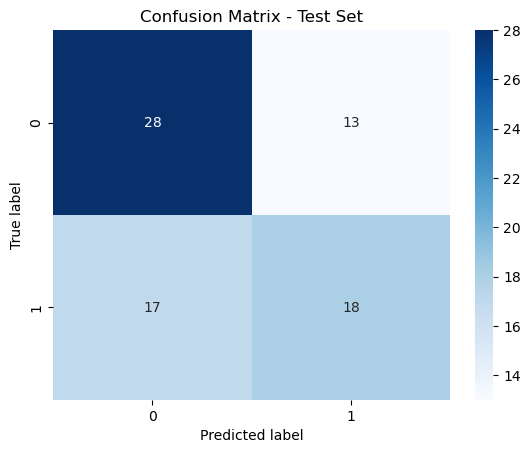

In [51]:
# Plot Confusion Matrix
def plot_confusion_matrix(cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# plot_confusion_matrix(confusion_matrix_train, 'Confusion Matrix - Train Set')
plot_confusion_matrix(confusion_matrix_test, 'Confusion Matrix - Test Set')

In [52]:
# Print Evaluation Metrics
print("Train Set:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 Score:", f1_train)
print("ROC AUC Score:", roc_auc_train)

print("\nTest Set:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)
print("ROC AUC Score:", roc_auc_test)

Train Set:
Accuracy: 0.9457364341085271
Precision: 0.990909090909091
Recall: 0.8934426229508197
F1 Score: 0.9396551724137931
ROC AUC Score: 0.9430448408871747

Test Set:
Accuracy: 0.6052631578947368
Precision: 0.5806451612903226
Recall: 0.5142857142857142
F1 Score: 0.5454545454545455
ROC AUC Score: 0.5986062717770034


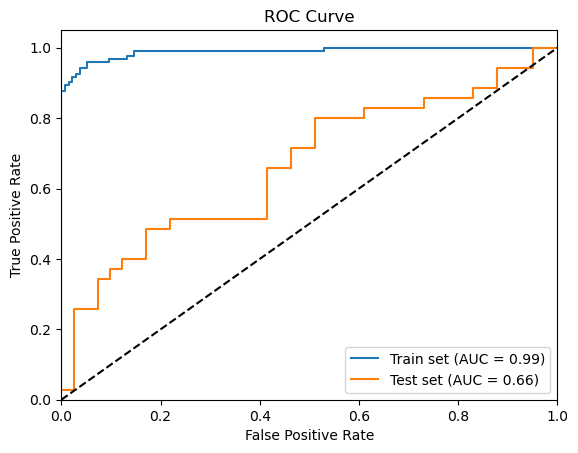

In [53]:
# Get predicted probabilities for the positive class
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate, true positive rate, and threshold for validation set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_proba_train)

# Calculate the false positive rate, true positive rate, and threshold for test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)

# Calculate the AUC for validation set
auc_train = roc_auc_score(y_train, y_pred_proba_train)

# Calculate the AUC for test set
auc_test = roc_auc_score(y_test, y_pred_proba_test)

# Plot the ROC curve
plt.plot(fpr_train, tpr_train, label='Train set (AUC = %0.2f)' % auc_train)
plt.plot(fpr_test, tpr_test, label='Test set (AUC = %0.2f)' % auc_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [54]:
# Predict on the test set
y_test_pred = best_model.predict(X_test)

# Calculate evaluation metrics
classification_report_test = classification_report(y_test, y_test_pred)
print("Test Set Metrics:\n", classification_report_test)

Test Set Metrics:
               precision    recall  f1-score   support

           0       0.62      0.68      0.65        41
           1       0.58      0.51      0.55        35

    accuracy                           0.61        76
   macro avg       0.60      0.60      0.60        76
weighted avg       0.60      0.61      0.60        76



In [55]:
df_F.shape

(327, 49)

In [56]:
len(y_pred_proba_test)

76

In [57]:
# Assuming you have already calculated y_pred_proba_test using best_model.predict_proba(X_test)[:, 1]
print("Predicted Probabilities (y_pred_proba_test):", y_pred_proba_test)

Predicted Probabilities (y_pred_proba_test): [0.6750753  0.25296709 0.24886585 0.54146523 0.42264445 0.46919779
 0.54569452 0.50130295 0.77724982 0.74455053 0.30591687 0.4875753
 0.40378441 0.27390176 0.62098938 0.63880956 0.72755275 0.65190216
 0.4388879  0.76152114 0.24642055 0.32617813 0.43146661 0.15861305
 0.1996548  0.54776822 0.65319153 0.42571917 0.42259243 0.10662669
 0.29327378 0.57782503 0.58855888 0.29615783 0.33286697 0.32985348
 0.12202635 0.5110639  0.25850332 0.34391218 0.68015441 0.47414882
 0.62144908 0.42868798 0.41190835 0.48915907 0.63912895 0.15724736
 0.54111196 0.56714679 0.49013757 0.41963951 0.12354223 0.44492311
 0.42274214 0.23412376 0.53834902 0.48707785 0.64859426 0.37865
 0.39566452 0.15123259 0.71967979 0.3204884  0.65841661 0.52437982
 0.69597488 0.22899326 0.31059231 0.46357437 0.55700437 0.19536319
 0.75783039 0.56911171 0.21145952 0.50531882]


In [58]:
# Threshold for classification
threshold = 0.5

# Create an array of zeros with the same length as y_test
y_pred = np.zeros_like(y_test)

# Assign 1 to indices where y_pred_proba_test is greater than or equal to the threshold
y_pred[y_pred_proba_test >= threshold] = 1

# Create y_pred_proba array by rounding the probabilities to two decimal places
y_pred_proba = np.round(y_pred_proba_test, 2)

# Print the values of y_pred and y_pred_proba
print("Predicted Labels (y_pred):", y_pred)
print("Predicted Probabilities (y_pred_proba):", y_pred_proba)

Predicted Labels (y_pred): [1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0
 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 1
 0 1]
Predicted Probabilities (y_pred_proba): [0.68 0.25 0.25 0.54 0.42 0.47 0.55 0.5  0.78 0.74 0.31 0.49 0.4  0.27
 0.62 0.64 0.73 0.65 0.44 0.76 0.25 0.33 0.43 0.16 0.2  0.55 0.65 0.43
 0.42 0.11 0.29 0.58 0.59 0.3  0.33 0.33 0.12 0.51 0.26 0.34 0.68 0.47
 0.62 0.43 0.41 0.49 0.64 0.16 0.54 0.57 0.49 0.42 0.12 0.44 0.42 0.23
 0.54 0.49 0.65 0.38 0.4  0.15 0.72 0.32 0.66 0.52 0.7  0.23 0.31 0.46
 0.56 0.2  0.76 0.57 0.21 0.51]


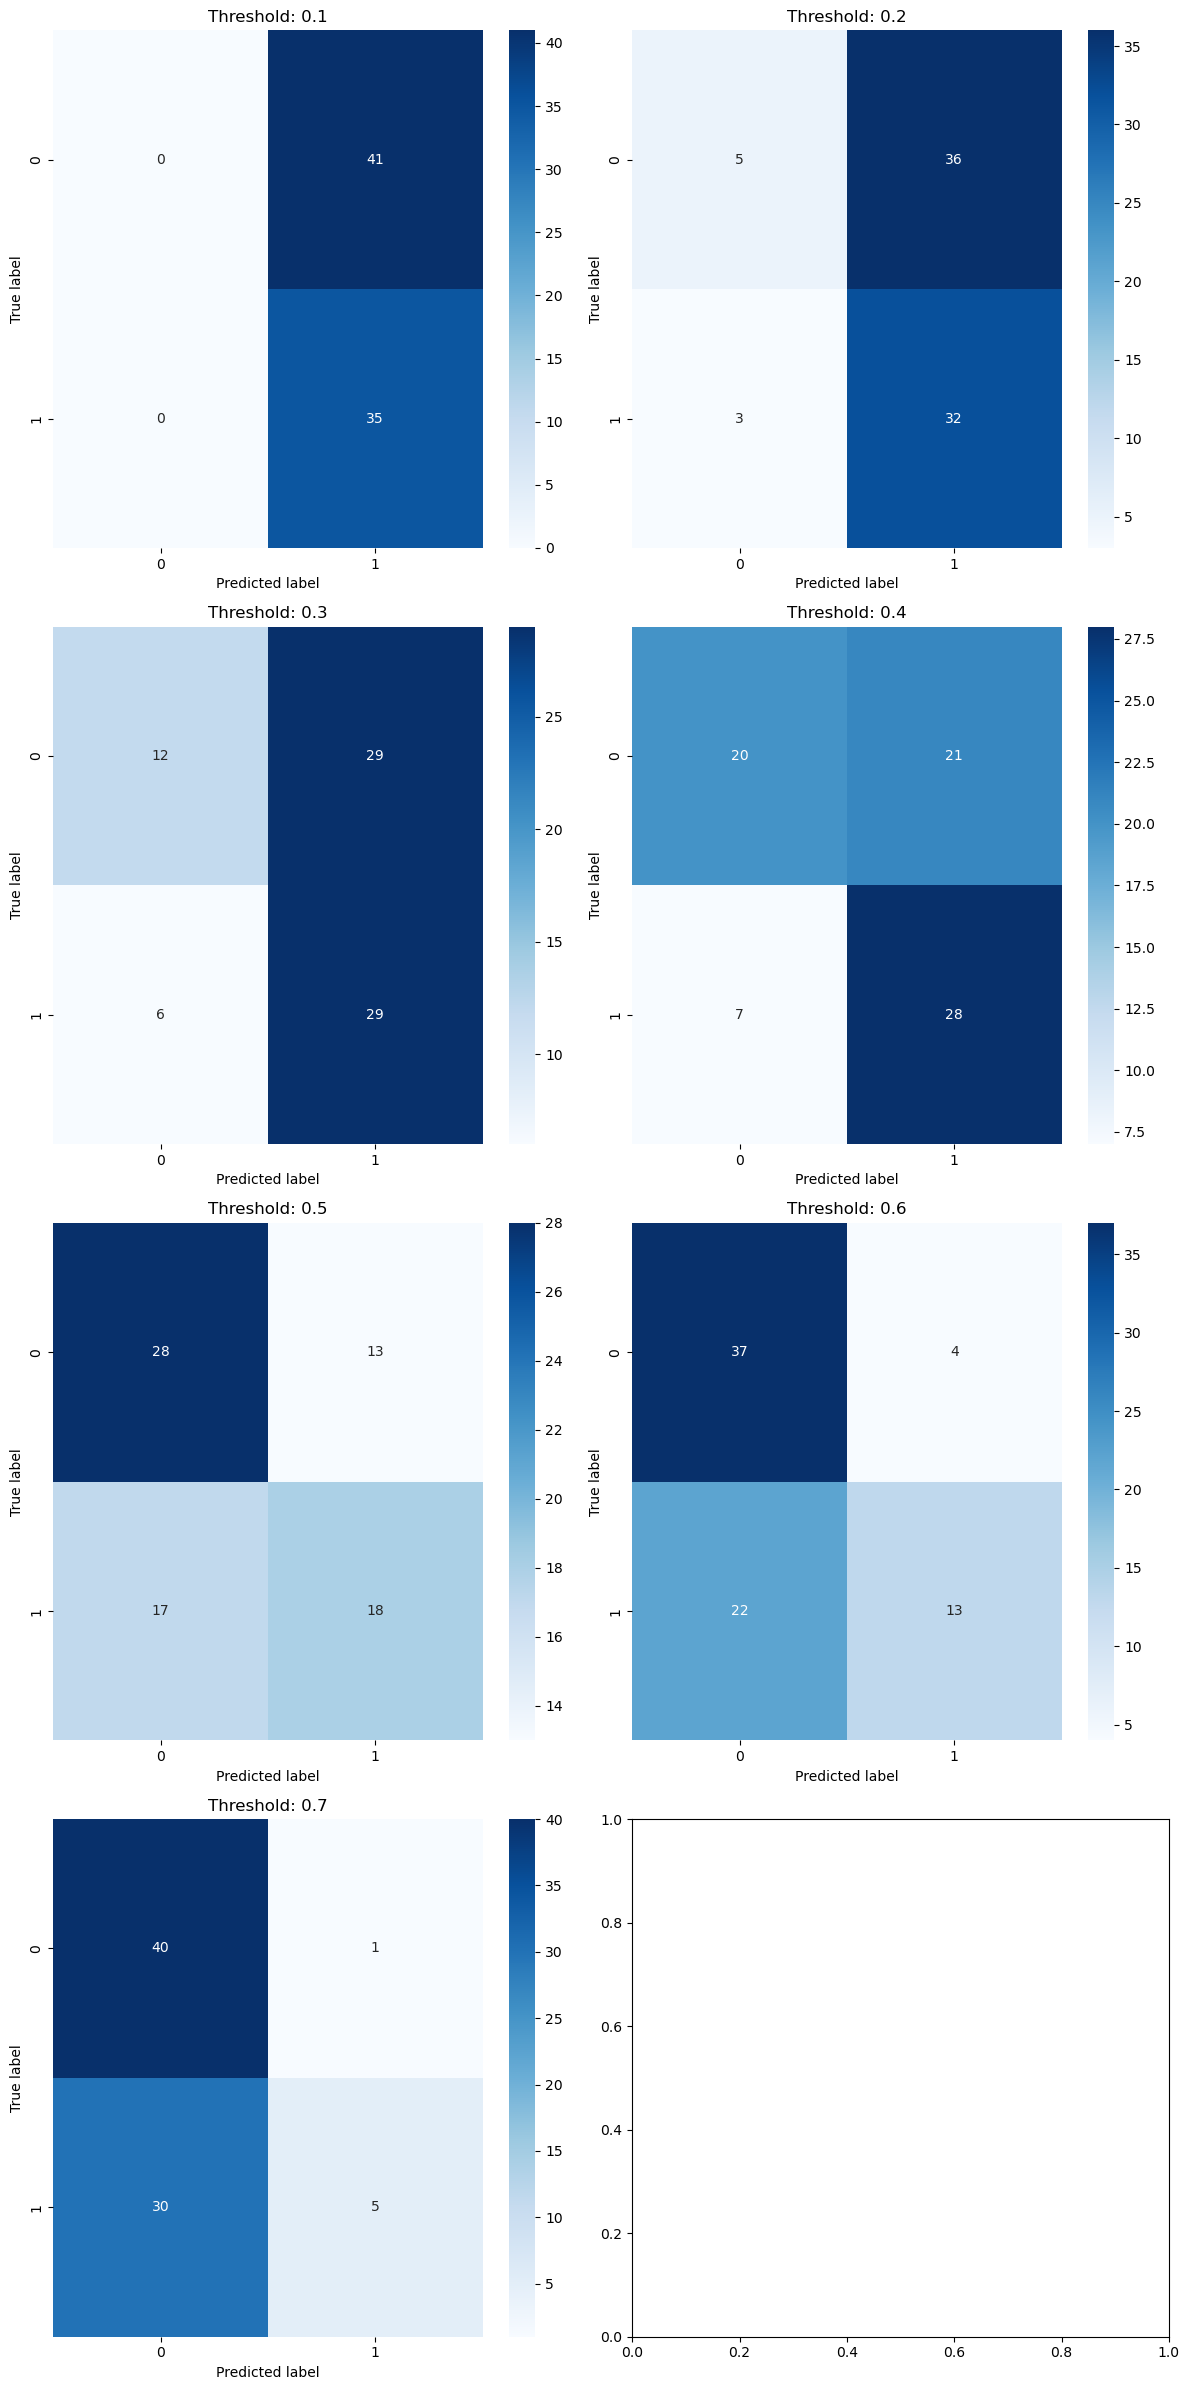

In [59]:
# Assuming you already have y_test, y_test_pred, and y_pred_proba_test calculated

thresholds = np.arange(0.1, 0.8, 0.1)  # Range of thresholds to try
confusion_matrices = []  # List to store confusion matrices for each threshold

for threshold in thresholds:
    y_test_pred_thresholded = np.where(y_pred_proba_test > threshold, 1, 0)  # Apply threshold to get thresholded predictions
    cm = confusion_matrix(y_test, y_test_pred_thresholded)  # Calculate confusion matrix
    confusion_matrices.append(cm)  # Add confusion matrix to the list

# Plot confusion matrices for each threshold
num_thresholds = len(thresholds)
num_plots_per_row = 2
num_rows = int(np.ceil(num_thresholds / num_plots_per_row))
fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(12, 6*num_rows))

for i, cm in enumerate(confusion_matrices):
    row_idx = i // num_plots_per_row
    col_idx = i % num_plots_per_row
    ax = axes[row_idx, col_idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title("Threshold: {:.1f}".format(thresholds[i]))
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

plt.tight_layout()
plt.show()

In [60]:
#df_F.to_csv('Undersampled_data.csv',index=False)

In [61]:
# df_F2 = pd.read_csv('Undersampled_data.csv',converters={'CIF_ID': str})

In [62]:
# df_F2.head()

In [64]:
# len(y_prredh)

In [65]:
import pickle
pickle.dump(best_model, open('best_model_2022_4.pkl', 'wb'))

## LOGISTIC REGRESSION

In [ ]:
# Perform feature selection using logistic regression with L1 regularization
logreg = LogisticRegression(penalty='l1', solver='liblinear')
logreg.fit(X_train, y_train)
model = SelectFromModel(logreg, prefit=True)

# Extract selected features
X_train_selected = model.transform(X_train)
X_test_selected = model.transform(X_test)

In [ ]:
# Define hyperparameters to tune
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform grid search cross-validation
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the final model with the best hyperparameters
final_model = LogisticRegression(solver='liblinear', **best_params)
final_model.fit(X_train, y_train)


In [ ]:
y_pred_train = final_model.predict(X_train)

# Calculate evaluation metrics
accuracy = accuracy_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
y_pred_test = final_model.predict(X_test)

# Calculate evaluation metrics
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

# Print evaluation metrics
print("Test Accuracy:", accuracy_test)
print("Test Precision:", precision_test)
print("Test Recall:", recall_test)
print("Test F1 Score:", f1_test)
print("Test roc_auc:", roc_auc_test)

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba_test = final_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

plt.plot(fpr_test, tpr_test, label='ROC curve (AUC = {:.2f})'.format(auc_score_test))
plt.plot([0, 1], [0, 1], 'k--')  # Plotting the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

In [ ]:
feature_importance = logreg.coef_[0]
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importance:\n", feature_importance_df)

In [ ]:
# Classification report for test set
print("Classification Report - Test Set")
print(classification_report(y_test, y_pred_test))

In [ ]:
# from sklearn.metrics import classification_report

# Predict on the test set
# y_test_pred = logreg.predict(X_test)

# Calculate evaluation metrics
# classification_report_test = classification_report(y_test, y_test_pred)
# print("Test Set Metrics:\n", classification_report_test)


### XGBOOST Classifier

In [ ]:
xgb_classifier = xgb.XGBClassifier()

In [ ]:
#Define the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': np.arange(0,1,0.2),
    'max_depth': np.arange(0,10,2),
    'n_estimators': np.arange(50,100,10),
    'scale_pos_weight': [1,2,3,4,5]
}


In [ ]:
# Rename columns in X_train_scaled
X_train.columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in X_train.columns]


In [ ]:
# Create the GridSearchCV object with the classifier and parameter grid
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

In [ ]:
# Get the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
# Rename the columns in the input data to match the expected feature names
X_test.rename(columns={
    'no_of_inactive_months_otg_0- <3': 'no_of_inactive_months_otg_0- 3',
    'no_of_inactive_months_otg_6- <9': 'no_of_inactive_months_otg_6- 9',
    'no_of_inactive_months_otg_3- <6': 'no_of_inactive_months_otg_3- 6'
}, inplace=True)

In [ ]:
# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

In [ ]:
classification_report = classification_report(y_test, y_pred)
print(classification_report)

In [ ]:
# Calculate the confusion matrix for the test set
cm_test = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

### TabNet --- Neural Network For Tabular Data.

In [ ]:
# Initialize and train the TABNET model
tabnet = TabNetClassifier()
tabnet.fit(X_train.values, y_train.values, eval_set=[(X_test.values, y_test.values)])

# Evaluate the model
y_pred = tabnet.predict(X_test.values)
accuracy = (y_pred == y_test.values).mean()
print("Accuracy:", accuracy)